# Import packages & functions

In [1]:
print("importing modules")
import os
import sys
import json
import argparse
import numpy as np
import time
import random
import string
import h5py
from tqdm import tqdm
import webdataset as wds
from PIL import Image
import pandas as pd
import nibabel as nib
import nilearn

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

import utils
from utils import load_preprocess_betas, resample, applyxfm, apply_thresh, resample_betas

# imports utils from mindeye_preproc as "preproc"
import importlib.util
parent_utils_path = "/home/ri4541/mindeye_preproc/analysis/utils.py"
spec = importlib.util.spec_from_file_location("utils", parent_utils_path)
preproc = importlib.util.module_from_spec(spec)
parent_dir = os.path.dirname(parent_utils_path)
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
spec.loader.exec_module(preproc)

if utils.is_interactive():
    from IPython.display import clear_output # function to clear print outputs in cell
    %load_ext autoreload 
    # this allows you to change functions in models.py or utils.py and have this notebook automatically update with your revisions
    %autoreload 2 
    
seed = utils.get_slurm_seed()

importing modules
SLURM seed not found, using default: 0


# Princeton data prep

## Load Data & Design

In [2]:
if utils.is_interactive():
    sub = "sub-005"
    session = "ses-01"
    task = 'C'  # 'study' or 'A'; used to search for functional run in bids format
else:
    sub = os.environ["sub"]
    session = os.environ["session"]
    task = os.environ["task"]

if session == "all":
    ses_list = ["ses-01", "ses-02"]  # list of actual session IDs
    design_ses_list = ["ses-01", "ses-02"]  # list of session IDs to search for design matrix
else:
    ses_list = [session]
    design_ses_list = [session]
    
task_name = f"_task-{task}" if task != 'study' else ''
resample_voxel_size = False
resample_post_glmsingle = False  # do you want to do voxel resampling here? if resample_voxel_size = True and resample_post_glmsingle = False, assume the resampling has been done prior to GLMsingle, so just use resampled directory but otherwise proceed as normal
load_from_resampled_file = False  # do you want to load resampled data from file? if True, assume resampling was done in this notebook before, and that we're not using the GLMsingle resampled data
    
train_test_split = 'MST' # 'MST', 'orig', 'unique'
remove_close_to_MST = False
remove_random_n = False

if remove_close_to_MST or remove_random_n:
    assert remove_close_to_MST != remove_random_n  # don't remove both sets of images

n_to_remove = 0
if remove_random_n:
    assert train_test_split == 'MST'  # MST images are excluded from the n images removed, so only makes sense if they're not in the training set
    n_to_remove = 150
    
if resample_voxel_size:
    # voxel size was unchanged in glmsingle, want to perform resampling here
    resampled_vox_size = 2.5
    resample_method = "sinc"  # {trilinear,nearestneighbour,sinc,spline}, credit: https://johnmuschelli.com/fslr/reference/flirt.help.html
    
    # file name helper variables
    vox_dim_str = str(resampled_vox_size).replace('.', '_')  # in case the voxel size has a decimal, replace with an underscore
    resampled_suffix = f"resampled_{vox_dim_str}mm_{resample_method}"
    mask_resampled_suffix = resampled_suffix
    if resample_post_glmsingle:
        resampled_suffix += '_postglmsingle'
    else:
        resampled_suffix += '_preglmsingle'

In [3]:
session_label = preproc.get_session_label(ses_list)
print('session label:', session_label)
n_runs, _ = preproc.get_runs_per_session(sub, session, ses_list)

session label: ses-01


In [4]:
if utils.is_interactive():
    glmsingle_path = f"/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_{sub}_{session_label}_task-{task}"
else:
    glmsingle_path = os.environ["glmsingle_path"]
    
designdir = "/home/ri4541/real_time_mindEye2"
print(glmsingle_path)

if resample_voxel_size:
    # option 1: we are using original (non-resampled) GLMsingle outputs and doing the resampling here
    # option 2: doing resampling pre-GLMsingle and using those outputs; no resampling involved here
    if resample_post_glmsingle:
        # option 1
        orig_glmsingle_path = glmsingle_path
        glmsingle_path += f"_{resampled_suffix}"
        print("resampled glmsingle path:", glmsingle_path)
        if load_from_resampled_file:
            # resampling is already done; load from file
             assert os.path.exists(glmsingle_path)  # the new directory must have been created if we reached here
        else:
            # don't load from file; do resampling here
            os.makedirs(glmsingle_path,exist_ok=True)
    else:
        # option 2
        glmsingle_path += f"_{resampled_suffix}"
        print("glmsingle path:", glmsingle_path)

assert os.path.exists(glmsingle_path)
print("glmsingle path exists!")

/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_sub-005_ses-01_task-C
glmsingle path exists!


In [5]:
data, starts, images, is_new_run, image_names, unique_images, len_unique_images = preproc.load_design_files(
    sub=sub,
    session=session,
    func_task_name=task,
    designdir=designdir,
    design_ses_list=design_ses_list
)

if sub == 'sub-001':
    if session == 'ses-01':
        assert image_names[0] == 'images/image_686_seed_1.png'
    elif session in ('ses-02', 'all'):
        assert image_names[0] == 'all_stimuli/special515/special_40840.jpg'
    elif session == 'ses-03':
        assert image_names[0] == 'all_stimuli/special515/special_69839.jpg'
    elif session == 'ses-04':
        assert image_names[0] == 'all_stimuli/rtmindeye_stimuli/image_686_seed_1.png'
elif sub == 'sub-003':
    assert image_names[0] == 'all_stimuli/rtmindeye_stimuli/image_686_seed_1.png'

unique_images = np.unique(image_names.astype(str))
unique_images = unique_images[(unique_images!="nan")]
len_unique_images = len(unique_images)
print("n_runs",n_runs)

if (sub == 'sub-001' and session == 'ses-04') or (sub == 'sub-003' and session == 'ses-01'):
    assert len(unique_images) == 851

print(image_names[:4])
print(starts[:4])
print(is_new_run[:4])

if remove_random_n:
    # want to remove 150 imgs
    # 100 special515 imgs are repeated 3x (300 total)
    # all other train imgs are only shown once (558 total)
    # of the 150, want to sample proportionally since we're cutting all repeats for special515
    # so take out 51 (17 unique) from special515 and 99 from rest = removing 150 total
    np.random.seed(seed)
    options_to_remove = [x for x in set(image_names) if str(x) != 'nan' and x != 'blank.jpg' and 'MST_pairs' not in x and 'special515' not in x and list(image_names).count(x)==1]  # all the imgs that only appear once (this is O(N^2) b/c of count() within list comprehension but image_names is a relatively small list)
    options_to_remove_special515 = [x for x in set(image_names) if str(x) != 'nan' and x != 'blank.jpg' and 'MST_pairs' not in x and 'special515' in x and list(image_names).count(x)>1]  # all the special515 images that are repeated (count()>1 necessary because there are special515 that are not repeated)
    imgs_to_remove = np.random.choice(options_to_remove, size=99, replace=False)
    imgs_to_remove = np.append(imgs_to_remove, np.random.choice(options_to_remove_special515, size=17, replace=False))

image_idx = np.array([])  # contains the unique index of each presented image
vox_image_names = np.array([])  # contains the names of the images corresponding to image_idx
all_MST_images = dict()
for i, im in enumerate(image_names):
    # skip if blank, nan
    if im == "blank.jpg":
        i+=1
        continue
    if str(im) == "nan":
        i+=1
        continue
    vox_image_names = np.append(vox_image_names, im)
    if remove_close_to_MST:  # optionally skip close_to_MST images 
        if "closest_pairs" in im:
            i+=1
            continue
    elif remove_random_n:
        if im in imgs_to_remove:
            i+=1
            continue
            
    image_idx_ = np.where(im==unique_images)[0].item()
    image_idx = np.append(image_idx, image_idx_)
    
    if (sub == 'sub-001' and session == 'ses-04') or (sub == 'sub-003' and session == 'ses-01'):  # MST images are ones that matched these image titles
        import re
        if ('w_' in im or 'paired_image_' in im or re.match(r'all_stimuli/rtmindeye_stimuli/\d{1,2}_\d{1,3}\.png$', im) or re.match(r'images/\d{1,2}_\d{1,3}\.png$', im)):  
        # the regexp here looks for **_***.png, allows 1-2 chars before underscore and 1-3 chars after it
            # print(im)
            all_MST_images[i] = im
            i+=1            
    elif 'MST' in im:
        all_MST_images[i] = im
        i+=1
    
image_idx = torch.Tensor(image_idx).long()
# for im in new_image_names[MST_images]:
#     assert 'MST_pairs' in im
# assert len(all_MST_images) == 300

unique_MST_images = np.unique(list(all_MST_images.values())) 

MST_ID = np.array([], dtype=int)
if remove_close_to_MST:
    close_to_MST_idx = np.array([], dtype=int)
if remove_random_n:
    random_n_idx = np.array([], dtype=int)

vox_idx = np.array([], dtype=int)
j=0  # this is a counter keeping track of the remove_random_n used later to index vox based on the removed images; unused otherwise
for i, im in enumerate(image_names):  # need unique_MST_images to be defined, so repeating the same loop structure
    # skip if blank, nan
    if im == "blank.jpg":
        i+=1
        continue
    if str(im) == "nan":
        i+=1
        continue
    if remove_close_to_MST:  # optionally skip close_to_MST images 
        if "closest_pairs" in im:
            close_to_MST_idx = np.append(close_to_MST_idx, i)
            i+=1
            continue
    if remove_random_n:
        if im in imgs_to_remove:
            vox_idx = np.append(vox_idx, j)
            i+=1
            j+=1
            continue
    j+=1
    curr = np.where(im == unique_MST_images)
    # print(curr)
    if curr[0].size == 0:
        MST_ID = np.append(MST_ID, np.array(len(unique_MST_images)))  # add a value that should be out of range based on the for loop, will index it out later
    else:
        MST_ID = np.append(MST_ID, curr)
        
assert len(MST_ID) == len(image_idx)
# assert len(np.argwhere(pd.isna(data['current_image']))) + len(np.argwhere(data['current_image'] == 'blank.jpg')) + len(image_idx) == len(data)
# MST_ID = torch.tensor(MST_ID[MST_ID != len(unique_MST_images)], dtype=torch.uint8)  # torch.tensor (lowercase) allows dtype kwarg, Tensor (uppercase) is an alias for torch.FloatTensor
print(MST_ID.shape)
if (sub == 'sub-001' and session == 'ses-04') or (sub == 'sub-003' and session == 'ses-01'):
    assert len(all_MST_images) == 100

Data shape: (780, 122)
Using design file: /home/ri4541/real_time_mindEye2/csv/sub-005_ses-01.csv
Total number of images: 770
Number of unique images: 532
n_runs 11
['all_stimuli/special515/special_15939.jpg'
 'all_stimuli/special515/special_23241.jpg'
 'all_stimuli/special515/special_32232.jpg'
 'all_stimuli/special515/special_34238.jpg']
[190.2773371 194.2907918 198.3011098 202.3095724]
[0. 0. 0. 0.]
(693,)


## Load images

In [6]:
import imageio.v2 as imageio
resize_transform = transforms.Resize((224, 224))
MST_images = []
images = None
for im_name in tqdm(image_idx):
    if sub == 'sub-001' and session == 'ses-01':
        image_file = f"all_stimuli/rtmindeye_stimuli/{unique_images[im_name]}"
    else:
        image_file = f"{unique_images[im_name]}"
    im = imageio.imread(image_file)
    im = torch.Tensor(im / 255).permute(2,0,1)
    im = resize_transform(im.unsqueeze(0))
    if images is None:
        images = im
    else:
        images = torch.vstack((images, im))
    if (sub == 'sub-001' and session == 'ses-04') or (sub == 'sub-003' and session == 'ses-01'):
        if ('w_' in image_file or 'paired_image_' in image_file or re.match(r'all_stimuli/rtmindeye_stimuli/\d{1,2}_\d{1,3}\.png$', image_file) or re.match(r'all_stimuli/rtmindeye_stimuli/images/\d{1,2}_\d{1,3}\.png$', image_file)):  
            MST_images.append(True)
        else:
            MST_images.append(False)
    else:   
        if ("MST_pairs" in image_file): # ("_seed_" not in unique_images[im_name]) and (unique_images[im_name] != "blank.jpg") 
            MST_images.append(True)
        else:
            MST_images.append(False)

print("images", images.shape)
MST_images = np.array(MST_images)
print("MST_images", len(MST_images))
if (sub == 'sub-001' and session == 'ses-04') or (sub == 'sub-003' and session == 'ses-01'):
    assert len(MST_images[MST_images==True]) == 100
print("MST_images==True", len(MST_images[MST_images==True]))

  0%|          | 0/693 [00:00<?, ?it/s]/home/ri4541/.conda/envs/rt_mindEye2/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 693/693 [00:10<00:00, 68.83it/s] 

images torch.Size([693, 3, 224, 224])
MST_images 693
MST_images==True 124


In [7]:
# want IDs of pairmates based on MST_images
# create "MST_pairmates" which is a 25x2 array with indices of the 25 pairs based on MST_images == True

assert unique_MST_images.shape[0] % 2 == 0  # make sure it's divisible by 2
MST_pairmate_names = unique_MST_images.reshape(int(unique_MST_images.shape[0]/2),2)
# print(MST_pairmate_names)

MST_pairmate_indices = np.empty(shape=MST_pairmate_names.shape, dtype=int)
for p, pair in enumerate(MST_pairmate_names):
    for i, im in enumerate(pair):
        MST_pairmate_indices[p][i] = np.where(np.isin(list(all_MST_images.values()), im))[0][0]  # just take the first repeated instance of an image
        
print(MST_pairmate_indices.shape, MST_pairmate_indices)

(31, 2) [[110  25]
 [ 15   6]
 [ 18  43]
 [ 95  49]
 [ 14  70]
 [ 12  20]
 [ 51  63]
 [ 87  50]
 [  2  58]
 [ 45   8]
 [ 27  39]
 [ 92  19]
 [ 55  33]
 [ 78  26]
 [  0  65]
 [ 32  28]
 [ 23  72]
 [ 54  91]
 [ 11  21]
 [ 76  13]
 [  5  34]
 [ 53  52]
 [ 66  40]
 [ 22  69]
 [107  24]
 [  7 106]
 [ 42   3]
 [ 44  10]
 [ 30   4]
 [ 86  60]
 [ 16  59]]


In [8]:
if (sub == 'sub-001' and session in ('ses-02', 'ses-03', 'all')):
    # MST_pairs contains the indices of repeats based on all_MST_images
    # all_MST_images contains the indices of images from image_names
    MST_pairs = utils.find_paired_indices(torch.tensor(MST_ID))
    MST_pairs = np.array(sorted(MST_pairs[:-1], key=lambda x: x[0]))  # we added a fake value as a placeholder so index out the last group of pairs

    # assert images[MST_pairs]

    fig, ax = plt.subplots(1, 3, figsize=(10,4))
    fig.suptitle('Sample MST pairs')

    ax[0].imshow(images[MST_pairs[-1][0]].permute(1,2,0).numpy())
    ax[0].set_title(f"Trial 0")

    ax[1].imshow(images[MST_pairs[-1][1]].permute(1,2,0).numpy())
    ax[1].set_title(f"Trial 1")

    ax[2].imshow(images[MST_pairs[-1][2]].permute(1,2,0).numpy())
    ax[2].set_title(f"Trial 2")

    plt.setp(ax, xticks=[], yticks=[])
    plt.tight_layout()
    plt.show()

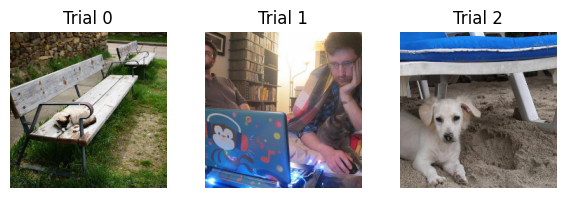

In [9]:
# pairs has the indices of all repeated images
pairs = utils.find_paired_indices(image_idx)
pairs = sorted(pairs, key=lambda x: x[0])

fig, axes = plt.subplots(1, 3, figsize=(6, 2))  # 1 row, 3 columns
for i, ax in enumerate(axes):
    ax.imshow(images[i].permute(1, 2, 0).numpy())
    ax.set_title(f"Trial {i}")
    ax.axis("off")  # Hide axes for better visualization

plt.tight_layout()
# output_path = os.path.join(output_dir, "trials_plot.png")
# plt.savefig(output_path, dpi=300)  # Save figure
plt.show()

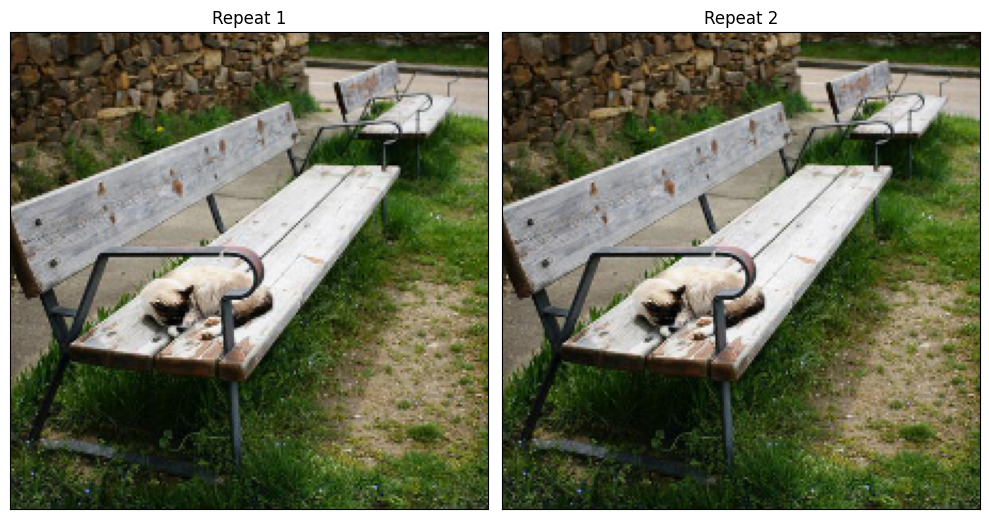

In [10]:
p=0

# plot 2 repeats (anything in pairs should have 2 repeats, even if there's more)
fig, ax = plt.subplots(1, 2, figsize=(10,8))

ax[0].imshow(images[pairs[p][0]].permute(1,2,0).numpy())
ax[0].set_title(f"Repeat 1")

ax[1].imshow(images[pairs[p][1]].permute(1,2,0).numpy())
ax[1].set_title(f"Repeat 2")

plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout()
plt.show()

In [11]:
if resample_voxel_size:
    from nilearn.masking import apply_mask, unmask
    ref_name = f'{glmsingle_path}/boldref_resampled.nii.gz'
    omat_name = f'{glmsingle_path}/boldref_omat'

In [89]:
from nilearn.plotting import plot_roi, plot_anat, plot_epi

mask_name = f'{glmsingle_path}/{sub}_{session_label}{task_name}_brain'
if resample_voxel_size:
    if resample_post_glmsingle is True:
        # use original mask directory
        mask_in_name = f'{orig_glmsingle_path}/{sub}_{session}{task_name}_brain.nii.gz'
        mask_out_name = mask_name + f"_{mask_resampled_suffix}.nii.gz"
        assert os.path.exists(mask_in_name)
        applyxfm(mask_in_name, ref_name, omat_name, resample_method, output=mask_out_name)
        apply_thresh(mask_out_name, 0.5, output=mask_out_name)  # binarize the mask since resampling can result in non- 0 or 1 values
    mask_name += f"_{mask_resampled_suffix}"

mask_name += ".nii.gz"
print(mask_name)
avg_mask = nib.load(mask_name)
# mask info
dimsize=avg_mask.header.get_zooms()
affine_mat = avg_mask.affine
brain=avg_mask.get_fdata()
xyz=brain.shape #xyz dimensionality of brain mask and epi data

print('Mask dimensions:', dimsize)
print('')
print('Affine:')
print(affine_mat)
print('')
print(f'There are {int(np.sum(brain))} voxels in the included brain mask\n')

/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_sub-005_ses-01_task-C/sub-005_ses-01_task-C_brain.nii.gz
Mask dimensions: (2.0, 2.0, 2.0)

Affine:
[[  2.           0.           0.         -76.29234314]
 [  0.           2.           0.         -84.79180908]
 [  0.           0.           2.         -62.80359268]
 [  0.           0.           0.           1.        ]]

There are 182242 voxels in the included brain mask



## Load GLMSingle voxel data

In [90]:
vox = None
needs_postprocessing = False
params = (session, ses_list, remove_close_to_MST, image_names, remove_random_n, vox_idx)

if resample_post_glmsingle == True:
    glm_save_path_resampled = f"{glmsingle_path}/vox_resampled.nii.gz"
    if load_from_resampled_file == True:
        # resampling was done in this notebook so we can load from file
        vox = nib.load(glm_save_path_resampled)
    else:
        # do resampling here
        assert os.path.exists(ref_name) and os.path.exists(omat_name), "need to generate the boldref and omat separately since we don't have access to the functional data here; either do so using flirt on the command line or copy over the glmsingle resampled outputs"
        vox = load_preprocess_betas(orig_glmsingle_path, *params)
        vox = resample_betas(orig_glmsingle_path, sub, session, task_name, vox, glmsingle_path, glm_save_path_resampled, ref_name, omat_name)
    needs_postprocessing = True

if vox is None:
    # either resampling was done in glmsingle or we aren't resampling 
    vox = load_preprocess_betas(glmsingle_path, *params)

if needs_postprocessing == True:
    vox = apply_mask(vox, avg_mask)
    vox = vox.reshape(-1, vox.shape[-1])  # flatten the 3D image into np array with shape (voxels, images)
    print(vox.shape)

assert len(vox) == len(image_idx)

vox (693, 1, 1, 182242)
vox (693, 182242)


### Load nsdgeneral ROI

In [91]:
nsdgeneral_path = f'{glmsingle_path}/{sub}_{session_label}{task_name}_nsdgeneral.nii.gz'  
print(nsdgeneral_path)
assert os.path.exists(nsdgeneral_path)
print(f"nsdgeneral path exists!")

/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_sub-005_ses-01_task-C/sub-005_ses-01_task-C_nsdgeneral.nii.gz
nsdgeneral path exists!


In [92]:
if resample_voxel_size:
    nsdgeneral_path = f'{glmsingle_path}/{sub}_task-{task}_nsdgeneral_resampled.nii.gz'  
    if resample_post_glmsingle:
        assert os.path.exists(orig_glmsingle_path)
        roi_in_path = f"{orig_glmsingle_path}/{sub}_task-{task}_nsdgeneral.nii.gz"  # the input file is the original nsdgeneral mask (without resampling), from the original glmsingle directory
        applyxfm(roi_in_path, ref_name, omat_name, resample_method, output=nsdgeneral_path)

(76, 90, 74)


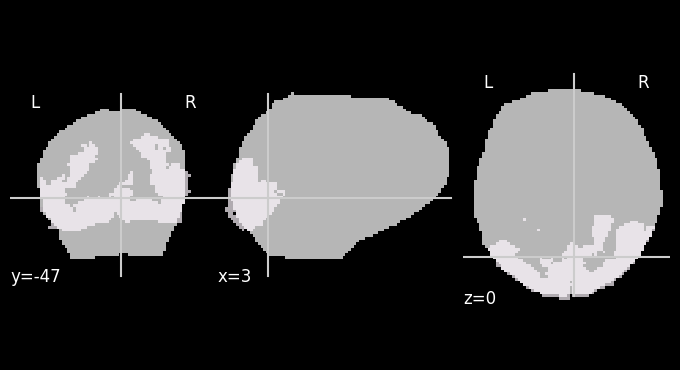

In [93]:
roi = nib.load(nsdgeneral_path)
print(roi.shape)
plot_roi(roi, bg_img=avg_mask)
plt.show()

In [94]:
avg_mask = avg_mask.get_fdata().flatten()
print(f"total voxels (whole brain) = {int(avg_mask.sum())}")

roi = roi.get_fdata()
roi = roi.flatten()
roi = roi[avg_mask.astype(bool)]
roi[np.isnan(roi)] = 0
roi = roi.astype(bool)
print(f"nsdgeneral voxels = {roi.sum()}")

total voxels (whole brain) = 182242
nsdgeneral voxels = 19264


### ROI voxel exclusion

In [95]:
# ROI masking?
print(f"vox before ROI exclusion: {vox.shape}")
vox = vox[:,roi]
print(f"vox after ROI exclusion: {vox.shape}")

if np.any(np.isnan(vox)):
    print("NaNs found! Removing voxels...")
    x,y = np.where(np.isnan(vox))
    vox = vox[:,np.setdiff1d(np.arange(vox.shape[-1]), y)]

vox before ROI exclusion: (693, 182242)
vox after ROI exclusion: (693, 19264)


## Reliability calculation

### Calculate reliability (corr between first and second presentation of same image) for every voxel

In [96]:
# results = []
# for i in pairs:
#     results.append(vox[i])

In [97]:
pairs_homog = np.array([[p[0], p[1]] for p in pairs])

In [98]:
# vox_pairs = []
# for i in pairs:
#     vox_pairs.append(utils.zscore(vox[i]))

vox_pairs = utils.zscore(vox[pairs_homog])
rels = np.full(vox.shape[-1],np.nan)
for v in tqdm(range(vox.shape[-1])):
    rels[v] = np.corrcoef(vox_pairs[:,0,v], vox_pairs[:,1,v])[1,0]
# for v in tqdm(range(vox[0].shape[-1])):
#     rep0 = []
#     rep1 = []

#     for vp in vox_pairs:
#         rep0.append(vp[0, v])
#         rep1.append(vp[1, v])

#     rels[v] = np.corrcoef(rep0, rep1)[1, 0]

print("rels", rels.shape)
assert np.sum(np.all(np.isnan(rels))) == 0

100%|██████████| 19264/19264 [00:01<00:00, 18006.66it/s]

rels (19264,)


### Create representational similarity matrix

In [99]:
# creating img x vox x repetitions matrix | shape=(150, 18419, 2)
vox0 = np.zeros((len(pairs_homog), vox.shape[-1], 2))
print(vox0.shape)
for ipair, pair in enumerate(tqdm(pairs_homog)):
    pair = pair[:2] # to keep things consistent, just using the first two repeats
    i,j = pair
    vox0[ipair, :, :] = vox[pair].T
vox_avg = vox0.mean(-1) # average across the repetitions

(112, 19264, 2)


100%|██████████| 112/112 [00:00<00:00, 6047.01it/s]


In [100]:
# Masking RDM for each reliability threshold
r_thresholds = np.array([.0, .1, .2, .3])
rdm = np.zeros((len(r_thresholds), len(pairs), len(pairs))) 
for ir_thresh, r_thresh in enumerate(r_thresholds):
    print(f"reliability threshold = {r_thresh}")
    for i in tqdm(range(len(pairs))):
        for j in range(len(pairs)):
            rdm[ir_thresh,i,j] = np.corrcoef(vox_avg[i,rels>r_thresh], 
                                             vox_avg[j,rels>r_thresh])[0,1]
# rdm is shape (4, 150, 150)

reliability threshold = 0.0


100%|██████████| 112/112 [00:03<00:00, 34.58it/s]


reliability threshold = 0.1


100%|██████████| 112/112 [00:02<00:00, 45.04it/s]


reliability threshold = 0.2


100%|██████████| 112/112 [00:01<00:00, 64.04it/s]


reliability threshold = 0.3


100%|██████████| 112/112 [00:01<00:00, 74.74it/s]


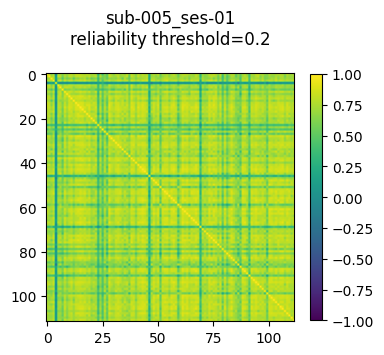

In [101]:
thresh = .2
plt.figure(figsize=(4,4))
plt.imshow(rdm[np.where(r_thresholds==thresh)[0].item()], clim=(-1,1))
plt.colorbar(shrink=0.8)
plt.title(f"{sub}_{session}\nreliability threshold={thresh}\n")
plt.show()

In [102]:
for thresh in range(rdm.shape[0]):
    for img in range(rdm.shape[1]):
        assert np.isclose(rdm[thresh, img, img], 1)

In [103]:
vox.shape

(693, 19264)

In [104]:
# Reliability thresholding?
print(f"\nvox before reliability thresholding: {vox.shape}")
vox = vox[:,rels>.2]
print(f"\nvox after reliability thresholding: {vox.shape}")


vox before reliability thresholding: (693, 19264)

vox after reliability thresholding: (693, 2794)


In [105]:
print(images.shape)
print(vox.shape)
assert len(images) == len(vox)

torch.Size([693, 3, 224, 224])
(693, 2794)


112 112


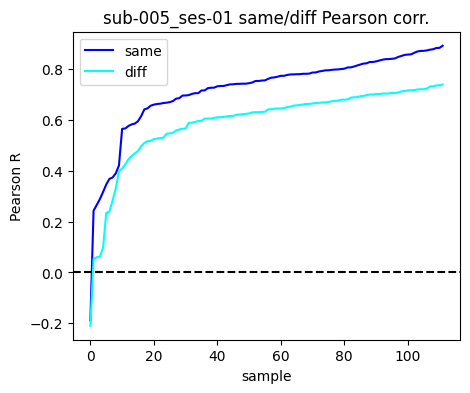

In [106]:
same_corrs = []
diff_corrs = []
for isamp, samp in enumerate(vox[pairs_homog]):
    avg_same_img = []
    for i in range(samp.shape[0]):
        for j in range(i, samp.shape[0]):
            if i != j:
                avg_same_img.append(np.array([np.corrcoef(samp[i, :], samp[j, :])[0,1]]))
    
    same_corrs.append(np.mean(avg_same_img))
                       
    avg_diff_img = []
    for isamp_j, samp_j in enumerate(vox[pairs_homog]):
        if isamp_j != isamp:
            for i in range(samp_j.shape[0]):
                for j in range(i, samp_j.shape[0]):
                    if i != j:
                        avg_diff_img.append(np.array([np.corrcoef(samp[i, :], samp_j[j, :])[0,1]]))
                                    
    # print(len(avg_diff_img))
    diff_corrs.append(np.mean(avg_diff_img))


print(len(same_corrs), len(diff_corrs))
same_corrs = np.array(same_corrs)
diff_corrs = np.array(diff_corrs)


plt.figure(figsize=(5,4))
plt.title(f"{sub}_{session} same/diff Pearson corr.")
plt.plot(np.sort(same_corrs),c='blue',label='same')
plt.plot(np.sort(diff_corrs),c='cyan',label='diff')
plt.axhline(0,c='k',ls='--')
plt.legend()
plt.xlabel("sample")
plt.ylabel("Pearson R")
plt.show()

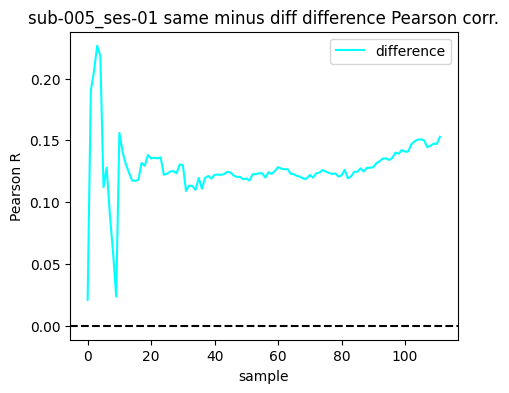

In [107]:
vox_pairs = utils.zscore(vox[pairs_homog])
plt.figure(figsize=(5,4))
plt.title(f"{sub}_{session} same minus diff difference Pearson corr.")
plt.plot(np.sort(same_corrs) - np.sort(diff_corrs),c='cyan',label='difference')
plt.axhline(0,c='k',ls='--')
plt.legend()
plt.xlabel("sample")
plt.ylabel("Pearson R")
plt.show()

# Training MindEye

In [108]:
utils.seed_everything(seed)

if train_test_split == 'orig':
    # train = all images except images that were repeated
    # test = average of the same-image presentations
    imageTrain = np.arange(len(images))
    train_image_indices = np.array([item for item in imageTrain if item not in pairs.flatten()])
    test_image_indices = pairs
    print(len(train_image_indices), len(test_image_indices))
    assert len(train_image_indices) + len(test_image_indices) == len(image_idx)
elif train_test_split == 'MST':
    # non-MST images are the train split
    # MST images are the test split
    vox_image_dict = {k:v for k,v in enumerate(vox_image_names)}
    vox, kept_indices = utils.filter_and_average_mst(vox, vox_image_dict)
    MST_images_filtered = MST_images[kept_indices]
    train_image_indices = np.where(MST_images_filtered == False)[0]  
    test_image_indices = np.where(MST_images_filtered == True)[0]
    print(len(train_image_indices), len(test_image_indices))
    assert len(train_image_indices) + len(test_image_indices) == len(vox)
elif train_test_split == 'unique':
    imageTest = np.arange(len(images))
    train_image_indices = pairs.flatten()
    test_image_indices = np.array([item for item in imageTest if item not in pairs.flatten()])
    print(len(train_image_indices), len(test_image_indices))
    assert len(train_image_indices) + len(test_image_indices) == len(image_idx)
else:
    raise Exception("invalid train_test_split")

# TODO add assertion that verifies file names in train and test don't overlap, guards against repeats

for i in train_image_indices:
    assert i not in test_image_indices

569 62


In [109]:
train_mean = np.mean(vox[train_image_indices],axis=0)
train_std = np.std(vox[train_image_indices],axis=0)

vox = utils.zscore(vox,train_mean=train_mean,train_std=train_std)
print("voxels have been zscored")
print(vox[:,0].mean(), vox[:,0].std())
print("vox", vox.shape)

images = images[kept_indices]

voxels have been zscored
-0.06510314 0.9861884
vox (631, 2794)


In [111]:
images = torch.Tensor(images)
vox = torch.Tensor(vox)
assert len(images) == len(vox)

In [112]:
### Multi-GPU config ###
from accelerate import Accelerator, DeepSpeedPlugin

local_rank = os.getenv('RANK')
if local_rank is None: 
    local_rank = 0
else:
    local_rank = int(local_rank)
print("LOCAL RANK ", local_rank)  

data_type = torch.float32 # change depending on your mixed_precision

accelerator = Accelerator(split_batches=False)
batch_size = 8 

LOCAL RANK  0


In [113]:
print("PID of this process =",os.getpid())
device = accelerator.device
print("device:",device)
world_size = accelerator.state.num_processes
distributed = not accelerator.state.distributed_type == 'NO'
num_devices = torch.cuda.device_count()
global_batch_size = batch_size * num_devices
print("global_batch_size", global_batch_size)
if num_devices==0 or not distributed: num_devices = 1
num_workers = num_devices
print(accelerator.state)

# set data_type to match your mixed precision (automatically set based on deepspeed config)
if accelerator.mixed_precision == "bf16":
    data_type = torch.bfloat16
elif accelerator.mixed_precision == "fp16":
    data_type = torch.float16
else:
    data_type = torch.float32

print("distributed =",distributed, "num_devices =", num_devices, "local rank =", local_rank, "world size =", world_size, "data_type =", data_type)
print = accelerator.print # only print if local_rank=0

PID of this process = 4005792
device: cuda
global_batch_size 8
Distributed environment: DistributedType.NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: no

distributed = False num_devices = 1 local rank = 0 world size = 1 data_type = torch.float32


## Configurations

In [114]:
# if running this interactively, can specify jupyter_args here for argparser to use
if utils.is_interactive():
    model_name = 'testing_MST' # 'sub-001_multi_bs24_MST_rishab_MSTsplit_remove_150_random_seed_0'
    print("model_name:", model_name)
    
    # global_batch_size and batch_size should already be defined in the above cells
    # other variables can be specified in the following string:
    # jupyter_args = f"--data_path=/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2 --model_name={model_name}"

    jupyter_args = f"--data_path=/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2 \
                    --model_name={model_name} \
                    --no-multi_subject --subj=1 --batch_size={batch_size} \
                    --hidden_dim=1024 --clip_scale=1. \
                    --no-blurry_recon --blur_scale=.5 \
                    --no-use_prior --prior_scale=30 \
                    --n_blocks=4 --max_lr=3e-4 --mixup_pct=.33 --num_epochs=30 --no-use_image_aug \
                    --ckpt_interval=999 --no-ckpt_saving --new_test \
                    --multisubject_ckpt=/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/train_logs/multisubject_subj01_1024hid_nolow_300ep"
    print(jupyter_args)
    jupyter_args = jupyter_args.split()

model_name: testing_MST
--data_path=/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2                     --model_name=testing_MST                     --no-multi_subject --subj=1 --batch_size=8                     --hidden_dim=1024 --clip_scale=1.                     --no-blurry_recon --blur_scale=.5                     --no-use_prior --prior_scale=30                     --n_blocks=4 --max_lr=3e-4 --mixup_pct=.33 --num_epochs=30 --no-use_image_aug                     --ckpt_interval=999 --no-ckpt_saving --new_test                     --multisubject_ckpt=/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/train_logs/multisubject_subj01_1024hid_nolow_300ep


In [115]:
parser = argparse.ArgumentParser(description="Model Training Configuration")
parser.add_argument(
    "--model_name", type=str, default="testing",
    help="name of model, used for ckpt saving and wandb logging (if enabled)",
)
parser.add_argument(
    "--data_path", type=str, default="/weka/proj-fmri/shared/natural-scenes-dataset",
    help="Path to where NSD data is stored / where to download it to",
)
parser.add_argument(
    "--subj",type=int, default=1, choices=[1,2,3,4,5,6,7,8],
    help="Validate on which subject?",
)
parser.add_argument(
    "--multisubject_ckpt", type=str, default=None,
    help="Path to pre-trained multisubject model to finetune a single subject from. multisubject must be False.",
)
parser.add_argument(
    "--num_sessions", type=int, default=0,
    help="Number of training sessions to include (if multi_subject, this variable doesnt matter)",
)
parser.add_argument(
    "--use_prior",action=argparse.BooleanOptionalAction,default=False,
    help="whether to train diffusion prior (True) or just rely on retrieval part of the pipeline (False)",
)
parser.add_argument(
    "--batch_size", type=int, default=32,
    help="Batch size can be increased by 10x if only training v2c and not diffusion diffuser",
)
parser.add_argument(
    "--wandb_log",action=argparse.BooleanOptionalAction,default=False,
    help="whether to log to wandb",
)
parser.add_argument(
    "--resume_from_ckpt",action=argparse.BooleanOptionalAction,default=False,
    help="if not using wandb and want to resume from a ckpt",
)
parser.add_argument(
    "--wandb_project",type=str,default="stability",
    help="wandb project name",
)
parser.add_argument(
    "--mixup_pct",type=float,default=.33,
    help="proportion of way through training when to switch from BiMixCo to SoftCLIP",
)
parser.add_argument(
    "--low_mem",action=argparse.BooleanOptionalAction,default=False,
    help="whether to preload images to cpu to speed things up but consume more memory",
)
parser.add_argument(
    "--blurry_recon",action=argparse.BooleanOptionalAction,default=True,
    help="whether to output blurry reconstructions",
)
parser.add_argument(
    "--blur_scale",type=float,default=.5,
    help="multiply loss from blurry recons by this number",
)
parser.add_argument(
    "--clip_scale",type=float,default=1.,
    help="multiply contrastive loss by this number",
)
parser.add_argument(
    "--prior_scale",type=float,default=30,
    help="multiply diffusion prior loss by this",
)
parser.add_argument(
    "--use_image_aug",action=argparse.BooleanOptionalAction,default=True,
    help="whether to use image augmentation",
)
parser.add_argument(
    "--num_epochs",type=int,default=120,
    help="number of epochs of training",
)
parser.add_argument(
    "--multi_subject",action=argparse.BooleanOptionalAction,default=False,
)
parser.add_argument(
    "--new_test",action=argparse.BooleanOptionalAction,default=True,
)
parser.add_argument(
    "--n_blocks",type=int,default=2,
)
parser.add_argument(
    "--hidden_dim",type=int,default=1024,
)
parser.add_argument(
    "--seq_past",type=int,default=0,
)
parser.add_argument(
    "--seq_future",type=int,default=0,
)
parser.add_argument(
    "--lr_scheduler_type",type=str,default='cycle',choices=['cycle','linear'],
)
parser.add_argument(
    "--ckpt_saving",action=argparse.BooleanOptionalAction,default=True,
)
parser.add_argument(
    "--ckpt_interval",type=int,default=5,
    help="save backup ckpt and reconstruct every x epochs",
)
parser.add_argument(
    "--seed",type=int,default=42,
)
parser.add_argument(
    "--max_lr",type=float,default=3e-4,
)

if utils.is_interactive():
    args = parser.parse_args(jupyter_args)
else:
    args = parser.parse_args()

# create global variables without the args prefix
for attribute_name in vars(args).keys():
    globals()[attribute_name] = getattr(args, attribute_name)
    
outdir = os.path.abspath(f'/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/train_logs/{model_name}')
if not os.path.exists(outdir) and ckpt_saving:
    os.makedirs(outdir,exist_ok=True)
    
if use_image_aug or blurry_recon:
    import kornia
    import kornia.augmentation as K
    from kornia.augmentation.container import AugmentationSequential
if use_image_aug:
    img_augment = AugmentationSequential(
        kornia.augmentation.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1, p=0.3),
        same_on_batch=False,
        data_keys=["input"],
    )
    # Define the blurring augmentations
    blur_augment = K.RandomGaussianBlur(kernel_size=(21, 21), sigma=(51.0, 51.0), p=1.)
    
if multi_subject:
    subj_list = np.arange(1,9)
    subj_list = subj_list[subj_list != subj]
else:
    subj_list = [subj]

print("subj_list", subj_list, "num_sessions", num_sessions)

subj_list [1] num_sessions 0


## Prep data, models, and dataloaders

In [116]:
if ckpt_saving:
    # save MST_ID for 2-alternative forced-choice retrieval evaluation 
    if 'MST' in model_name:
        eval_dir = os.environ["eval_dir"]
        print('saving MST info in', eval_dir)
        # Saving ##
        if not os.path.exists(eval_dir):
            os.mkdir(eval_dir)

        np.save(f"{eval_dir}/MST_ID.npy", MST_ID)
        np.save(f"{eval_dir}/MST_pairmate_indices.npy", MST_pairmate_indices)

    if remove_random_n:
        np.save(f"{eval_dir}/imgs_to_remove.npy", imgs_to_remove)

    np.save(f"{eval_dir}/train_image_indices.npy", train_image_indices)
    np.save(f"{eval_dir}/test_image_indices.npy", test_image_indices)
    np.save(f"{eval_dir}/images.npy", images)
    np.save(f"{eval_dir}/vox.npy", vox)

### Creating wds dataloader, preload betas and all 73k possible images

In [117]:
def my_split_by_node(urls): return urls
num_voxels_list = []

if multi_subject:
    nsessions_allsubj=np.array([40, 40, 32, 30, 40, 32, 40, 30])
    num_samples_per_epoch = (750*40) // num_devices 
else:
    # num_samples_per_epoch = (750*num_sessions) // num_devices 
    num_samples_per_epoch = len(train_image_indices)

print("dividing batch size by subj_list, which will then be concatenated across subj during training...") 
batch_size = batch_size // len(subj_list)

num_iterations_per_epoch = num_samples_per_epoch // (batch_size*len(subj_list))

print("batch_size =", batch_size, "num_iterations_per_epoch =",num_iterations_per_epoch, "num_samples_per_epoch =",num_samples_per_epoch)

dividing batch size by subj_list, which will then be concatenated across subj during training...
batch_size = 8 num_iterations_per_epoch = 71 num_samples_per_epoch = 569


In [118]:
train_data = {}
train_dl = {}

train_data[f'subj0{subj}'] = torch.utils.data.TensorDataset(torch.tensor(train_image_indices))
test_data = torch.utils.data.TensorDataset(torch.tensor(test_image_indices))

In [119]:
num_voxels = {}
voxels = {}
for s in subj_list:
    print(f"Training with {num_sessions} sessions")
    train_dl = torch.utils.data.DataLoader(train_data[f'subj0{s}'], batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

    num_voxels_list.append(vox[0].shape[-1])
    num_voxels[f'subj0{s}'] = vox[0].shape[-1]
    voxels[f'subj0{s}'] = vox
    print(f"num_voxels for subj0{s}: {num_voxels[f'subj0{s}']}")

print("Loaded all subj train dls and vox!\n")

# Validate only on one subject
if multi_subject: 
    subj = subj_list[0] # cant validate on the actual held out person so picking first in subj_list
test_dl = torch.utils.data.DataLoader(test_data, batch_size=24, shuffle=False, drop_last=True, pin_memory=True)

print(f"Loaded test dl for subj{subj}!\n")

Training with 0 sessions
num_voxels for subj01: 2794
Loaded all subj train dls and vox!

Loaded test dl for subj1!



## Load models

### CLIP image embeddings  model

In [120]:
## USING OpenCLIP ViT-bigG ###
sys.path.append('generative_models/')
import sgm
from generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder
# from generative_models.sgm.models.diffusion import DiffusionEngine
# from omegaconf import OmegaConf

try:
    print(clip_img_embedder)
except:
    clip_img_embedder = FrozenOpenCLIPImageEmbedder(
        arch="ViT-bigG-14",
        version="laion2b_s39b_b160k",
        output_tokens=True,
        only_tokens=True,
    )
    clip_img_embedder.to(device)
clip_seq_dim = 256
clip_emb_dim = 1664

# ## USING OPEN AI CLIP ViT-L ###
# import clip
# try:
#     print(clip_model)
# except:
#     clip_model, preprocess = clip.load("ViT-L/14", device=device)
#     preprocess = transforms.Compose([
#         transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR),
#         transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
#                              std=[0.26862954, 0.26130258, 0.27577711]),
#     ])
# def clip_img_embedder(image):
#     preproc_img = preprocess(image)
#     return clip_model.encode_image(preproc_img)
# clip_seq_dim = 1
# clip_emb_dim = 768

FrozenOpenCLIPImageEmbedder(
  (model): CLIP(
    (visual): VisionTransformer(
      (conv1): Conv2d(3, 1664, kernel_size=(14, 14), stride=(14, 14), bias=False)
      (patch_dropout): Identity()
      (ln_pre): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): ModuleList(
          (0-47): 48 x ResidualAttentionBlock(
            (ln_1): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=1664, out_features=1664, bias=True)
            )
            (ls_1): Identity()
            (ln_2): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=1664, out_features=8192, bias=True)
              (gelu): GELU(approximate='none')
              (c_proj): Linear(in_features=8192, out_features=1664, bias=True)
            )
            (ls_2): Identity()


### MindEye modules

In [121]:
model = utils.prepare_model_and_training(
    num_voxels_list=num_voxels_list,
    n_blocks=n_blocks,
    hidden_dim=hidden_dim,
    clip_emb_dim=clip_emb_dim,
    clip_seq_dim=clip_seq_dim,
    use_prior=use_prior,
    clip_scale=clip_scale
)

MindEyeModule()
param counts:
2,862,080 total
2,862,080 trainable
param counts:
2,862,080 total
2,862,080 trainable
param counts:
453,360,280 total
453,360,280 trainable
param counts:
456,222,360 total
456,222,360 trainable


In [122]:
# test on subject 1 with fake data
b = torch.randn((2,1,num_voxels_list[0]))
print(b.shape, model.ridge(b,0).shape)

torch.Size([2, 1, 2794]) torch.Size([2, 1, 1024])


In [123]:
# test that the model works on some fake data
b = torch.randn((2,1,hidden_dim))
print("b.shape",b.shape)

backbone_, clip_, blur_ = model.backbone(b)
print(backbone_.shape, clip_.shape, blur_[0].shape, blur_[1].shape)

b.shape torch.Size([2, 1, 1024])
torch.Size([2, 256, 1664]) torch.Size([2, 256, 1664]) torch.Size([1]) torch.Size([1])


### Adding diffusion prior + unCLIP if use_prior=True

In [124]:
if use_prior:
    from models import *

    # setup diffusion prior network
    out_dim = clip_emb_dim
    depth = 6
    dim_head = 52
    heads = clip_emb_dim//52 # heads * dim_head = clip_emb_dim
    timesteps = 100

    prior_network = VersatileDiffusionPriorNetwork(
            dim=out_dim,
            depth=depth,
            dim_head=dim_head,
            heads=heads,
            causal=False,
            num_tokens = clip_seq_dim,
            learned_query_mode="pos_emb"
        )

    model.diffusion_prior = BrainDiffusionPrior(
        net=prior_network,
        image_embed_dim=out_dim,
        condition_on_text_encodings=False,
        timesteps=timesteps,
        cond_drop_prob=0.2,
        image_embed_scale=None,
    )
    
    utils.count_params(model.diffusion_prior)
    utils.count_params(model)

### Setup optimizer / lr / ckpt saving

In [125]:
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']

opt_grouped_parameters = [
    {'params': [p for n, p in model.ridge.named_parameters()], 'weight_decay': 1e-2},
    {'params': [p for n, p in model.backbone.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-2},
    {'params': [p for n, p in model.backbone.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
]
# model.backbone.requires_grad_(False)

if use_prior:
    opt_grouped_parameters.extend([
        {'params': [p for n, p in model.diffusion_prior.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-2},
        {'params': [p for n, p in model.diffusion_prior.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ])

optimizer = torch.optim.AdamW(opt_grouped_parameters, lr=max_lr)

if lr_scheduler_type == 'linear':
    lr_scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer,
        total_iters=int(np.floor(num_epochs*num_iterations_per_epoch)),
        last_epoch=-1
    )
elif lr_scheduler_type == 'cycle':
    if num_iterations_per_epoch==0:
        num_iterations_per_epoch=1
    total_steps=int(np.floor(num_epochs*num_iterations_per_epoch))
    print("total_steps", total_steps)
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=max_lr,
        total_steps=total_steps,
        final_div_factor=1000,
        last_epoch=-1, pct_start=2/num_epochs
    )
    
def save_ckpt(tag):
    ckpt_path = outdir+f'/{tag}.pth'
    if accelerator.is_main_process:
        unwrapped_model = accelerator.unwrap_model(model)
        torch.save({
            'epoch': epoch,
            'model_state_dict': unwrapped_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler': lr_scheduler.state_dict(),
            'train_losses': losses,
            'test_losses': test_losses,
            'lrs': lrs,
            }, ckpt_path)
    print(f"\n---saved {outdir}/{tag} ckpt!---\n")

def load_ckpt(tag,load_lr=True,load_optimizer=True,load_epoch=True,strict=True,outdir=outdir,multisubj_loading=False): 
    print(f"\n---loading {outdir}/{tag}.pth ckpt---\n")
    checkpoint = torch.load(outdir+'/last.pth', map_location='cpu')
    state_dict = checkpoint['model_state_dict']
    if multisubj_loading: # remove incompatible ridge layer that will otherwise error
        state_dict.pop('ridge.linears.0.weight',None)
    model.load_state_dict(state_dict, strict=strict)
    if load_epoch:
        globals()["epoch"] = checkpoint['epoch']
        print("Epoch",epoch)
    if load_optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if load_lr:
        lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
    del checkpoint

print("\nDone with model preparations!")
num_params = utils.count_params(model)

total_steps 2130

Done with model preparations!
param counts:
456,222,360 total
456,222,360 trainable


# Wandb

In [126]:
if local_rank==0 and wandb_log: # only use main process for wandb logging
    import wandb
    import time
    
    wandb_project = 'rtmindeye'
    print(f"wandb {wandb_project} run {model_name}")

    # Need to configure wandb beforehand in terminal with "wandb init"!
    wandb_config = {
        "model_name": model_name,
        "global_batch_size": global_batch_size,
        "batch_size": batch_size,
        "num_epochs": num_epochs,
        "num_sessions": num_sessions,
        "num_params": num_params,
        "clip_scale": clip_scale,
        "prior_scale": prior_scale,
        "blur_scale": blur_scale,
        "use_image_aug": use_image_aug,
        "max_lr": max_lr,
        "mixup_pct": mixup_pct,
        "num_samples_per_epoch": num_samples_per_epoch,
        "ckpt_interval": ckpt_interval,
        "ckpt_saving": ckpt_saving,
        "seed": seed,  # SLURM array task ID
        "distributed": distributed,
        "num_devices": num_devices,
        "world_size": world_size,
    }
    print("wandb_config:\n", wandb_config)
    print("wandb_id:", model_name)

    # Initialize wandb
    wandb.init(
        id=model_name,
        project=wandb_project,
        name=model_name,
        config=wandb_config,
        resume="allow",
        save_code=True,
    )

    # Get SLURM job & array ID
    slurm_job_id = utils.get_slurm_job()
    slurm_array_id = seed  # seed corresponds to SLURM_ARRAY_TASK_ID

    # Define SLURM log paths
    log_dir = "slurms"
    log_files = [
        f"{log_dir}/{slurm_job_id}_{slurm_array_id}.out",
        f"{log_dir}/{slurm_job_id}_{slurm_array_id}.err",
    ]

    # Ensure logs exist before logging them
    for log_file in log_files:
        wait_time = 0
        while not os.path.exists(log_file) and wait_time < 60:  # Wait max 60s
            time.sleep(5)
            wait_time += 5

    # Log SLURM logs as artifacts
    artifact = wandb.Artifact(f"slurm_logs_{slurm_job_id}_{slurm_array_id}", type="logs")
    for log_file in log_files:
        if os.path.exists(log_file):
            artifact.add_file(log_file)

    wandb.log_artifact(artifact)
else:
    wandb_log = False

# Train the model

In [127]:
epoch = 0
losses, test_losses, lrs = [], [], []
best_test_loss = 1e9
torch.cuda.empty_cache()

In [128]:
# load multisubject stage1 ckpt if set
if multisubject_ckpt is not None and not resume_from_ckpt:
    load_ckpt("last",outdir=multisubject_ckpt,load_lr=False,load_optimizer=False,load_epoch=False,strict=False,multisubj_loading=True)


---loading /scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/train_logs/multisubject_subj01_1024hid_nolow_300ep/last.pth ckpt---



In [129]:
# checkpoint = torch.load(multisubject_ckpt+'/last.pth', map_location='cpu')
# state_dict = checkpoint['model_state_dict']
# model.load_state_dict(state_dict, strict=False)

In [130]:
# train_dls = [train_dl[f'subj0{s}'] for s in subj_list]

model, optimizer, train_dl, lr_scheduler = accelerator.prepare(model, optimizer, train_dl, lr_scheduler)
# leaving out test_dl since we will only have local_rank 0 device do evals

In [131]:
print(f"{model_name} starting with epoch {epoch} / {num_epochs}")
progress_bar = tqdm(range(epoch,num_epochs), ncols=1200, disable=(local_rank!=0))
test_image, test_voxel = None, None
mse = nn.MSELoss()
l1 = nn.L1Loss()
soft_loss_temps = utils.cosine_anneal(0.004, 0.0075, num_epochs - int(mixup_pct * num_epochs))
skip_train = True if epoch>=(num_epochs-1) else False # skip training if you are resuming from a fully trained model

for epoch in progress_bar:
    model.train()

    fwd_percent_correct = 0.
    bwd_percent_correct = 0.
    test_fwd_percent_correct = 0.
    test_bwd_percent_correct = 0.
    
    recon_cossim = 0.
    test_recon_cossim = 0.
    recon_mse = 0.
    test_recon_mse = 0.

    loss_clip_total = 0.
    loss_blurry_total = 0.
    loss_blurry_cont_total = 0.
    test_loss_clip_total = 0.
    
    loss_prior_total = 0.
    test_loss_prior_total = 0.

    blurry_pixcorr = 0.
    test_blurry_pixcorr = 0. 

    # you now have voxel_iters and image_iters with num_iterations_per_epoch batches each
    for train_i, behav in enumerate(train_dl):  
        with torch.cuda.amp.autocast(dtype=data_type):
            optimizer.zero_grad()
            loss = 0.
            
            behav = behav[0]

            image = images[behav.long().cpu()].to(device)
            voxel = vox[behav.long().cpu()]
            # voxel = (voxel - train_mean) / train_std
            voxel = torch.Tensor(voxel).unsqueeze(1).to(device)

            if use_image_aug: 
                image = img_augment(image)

            clip_target = clip_img_embedder(image)
            assert not torch.any(torch.isnan(clip_target))

            if epoch < int(mixup_pct * num_epochs):
                voxel, perm, betas, select = utils.mixco(voxel)

            voxel_ridge = model.ridge(voxel,0) #[model.ridge(voxel_list[si],si) for si,s in enumerate(subj_list)]
            # voxel_ridge = torch.cat(voxel_ridge_list, dim=0)

            backbone, clip_voxels, blurry_image_enc_ = model.backbone(voxel_ridge)

            if clip_scale>0:
                clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1)
                clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)

            if use_prior:
                loss_prior, prior_out = model.diffusion_prior(text_embed=backbone, image_embed=clip_target)
                loss_prior_total += loss_prior.item()
                loss_prior *= prior_scale
                loss += loss_prior

                recon_cossim += nn.functional.cosine_similarity(prior_out, clip_target).mean().item()
                recon_mse += mse(prior_out, clip_target).item()

            if clip_scale>0:
                if epoch < int(mixup_pct * num_epochs):                
                    loss_clip = utils.mixco_nce(
                        clip_voxels_norm,
                        clip_target_norm,
                        temp=.006,
                        perm=perm, betas=betas, select=select)
                else:
                    epoch_temp = soft_loss_temps[epoch-int(mixup_pct*num_epochs)]
                    loss_clip = utils.soft_clip_loss(
                        clip_voxels_norm,
                        clip_target_norm,
                        temp=epoch_temp)

                loss_clip_total += loss_clip.item()
                loss_clip *= clip_scale
                loss += loss_clip

            if blurry_recon:     
                image_enc_pred, transformer_feats = blurry_image_enc_

                image_enc = autoenc.encode(2*image-1).latent_dist.mode() * 0.18215
                loss_blurry = l1(image_enc_pred, image_enc)
                loss_blurry_total += loss_blurry.item()

                if epoch < int(mixup_pct * num_epochs):
                    image_enc_shuf = image_enc[perm]
                    betas_shape = [-1] + [1]*(len(image_enc.shape)-1)
                    image_enc[select] = image_enc[select] * betas[select].reshape(*betas_shape) + \
                        image_enc_shuf[select] * (1 - betas[select]).reshape(*betas_shape)

                image_norm = (image - mean)/std
                image_aug = (blur_augs(image) - mean)/std
                _, cnx_embeds = cnx(image_norm)
                _, cnx_aug_embeds = cnx(image_aug)

                cont_loss = utils.soft_cont_loss(
                    nn.functional.normalize(transformer_feats.reshape(-1, transformer_feats.shape[-1]), dim=-1),
                    nn.functional.normalize(cnx_embeds.reshape(-1, cnx_embeds.shape[-1]), dim=-1),
                    nn.functional.normalize(cnx_aug_embeds.reshape(-1, cnx_embeds.shape[-1]), dim=-1),
                    temp=0.2)
                loss_blurry_cont_total += cont_loss.item()

                loss += (loss_blurry + 0.1*cont_loss) * blur_scale #/.18215

            if clip_scale>0:
                # forward and backward top 1 accuracy        
                labels = torch.arange(len(clip_voxels_norm)).to(clip_voxels_norm.device) 
                fwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_voxels_norm, clip_target_norm), labels, k=1).item()
                bwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_target_norm, clip_voxels_norm), labels, k=1).item()

            if blurry_recon:
                with torch.no_grad():
                    # only doing pixcorr eval on a subset of the samples per batch because its costly & slow to compute autoenc.decode()
                    random_samps = np.random.choice(np.arange(len(image)), size=len(image)//5, replace=False)
                    blurry_recon_images = (autoenc.decode(image_enc_pred[random_samps]/0.18215).sample/ 2 + 0.5).clamp(0,1)
                    pixcorr = utils.pixcorr(image[random_samps], blurry_recon_images)
                    blurry_pixcorr += pixcorr.item()
            
            utils.check_loss(loss)
            accelerator.backward(loss)
            optimizer.step()

            losses.append(loss.item())
            lrs.append(optimizer.param_groups[0]['lr'])

            if lr_scheduler_type is not None:
                lr_scheduler.step()
                
            if train_i >= num_iterations_per_epoch-1:
                break
                
    model.eval()
    if local_rank==0:
        with torch.no_grad(), torch.cuda.amp.autocast(dtype=data_type): 
            for test_i, behav in enumerate(test_dl):  
                behav = behav[0]

                loss=0.

                if behav.ndim>1:
                    image = images[behav[:,0].long().cpu()].to(device)
                    voxel = vox[behav.long().cpu()].mean(1)
                else:
                    image = images[behav.long().cpu()].to(device)
                    voxel = vox[behav.long().cpu()]
                    
                voxel = torch.Tensor(voxel).unsqueeze(1).to(device)

                clip_img_embedder = clip_img_embedder.to(device)
                clip_target = clip_img_embedder(image.float())
                
                voxel_ridge = model.ridge(voxel,0)

                backbone, clip_voxels, blurry_image_enc_ = model.backbone(voxel_ridge)

                if clip_scale>0:
                    clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1)
                    clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)
                
                # for some evals, only doing a subset of the samples per batch because of computational cost
                random_samps = np.random.choice(np.arange(len(image)), size=len(image)//5, replace=False)
                
                if use_prior:
                    loss_prior, contaminated_prior_out = model.diffusion_prior(text_embed=backbone[random_samps], image_embed=clip_target[random_samps])
                    test_loss_prior_total += loss_prior.item()
                    loss_prior *= prior_scale
                    loss += loss_prior
                        
                if clip_scale>0:
                    loss_clip = utils.soft_clip_loss(
                        clip_voxels_norm,
                        clip_target_norm,
                        temp=.006)

                    test_loss_clip_total += loss_clip.item()
                    loss_clip = loss_clip * clip_scale
                    loss += loss_clip

                if blurry_recon:
                    image_enc_pred, _ = blurry_image_enc_
                    blurry_recon_images = (autoenc.decode(image_enc_pred[random_samps]/0.18215).sample / 2 + 0.5).clamp(0,1)
                    pixcorr = utils.pixcorr(image[random_samps], blurry_recon_images)
                    test_blurry_pixcorr += pixcorr.item()

                if clip_scale>0:
                    # forward and backward top 1 accuracy        
                    labels = torch.arange(len(clip_voxels_norm)).to(clip_voxels_norm.device) 
                    test_fwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_voxels_norm, clip_target_norm), labels, k=1).item()
                    test_bwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_target_norm, clip_voxels_norm), labels, k=1).item()
                
                utils.check_loss(loss)                
                test_losses.append(loss.item())

            # if utils.is_interactive(): clear_output(wait=True)
            if skip_train: break
            print("---")

            # assert (test_i+1) == 1
            logs = {"train/loss": np.mean(losses[-(train_i+1):]),
                "test/loss": np.mean(test_losses[-(test_i+1):]),
                "train/lr": lrs[-1],
                "train/num_steps": len(losses),
                "test/num_steps": len(test_losses),
                "train/fwd_pct_correct": fwd_percent_correct / (train_i + 1),
                "train/bwd_pct_correct": bwd_percent_correct / (train_i + 1),
                "test/test_fwd_pct_correct": test_fwd_percent_correct / (test_i + 1),
                "test/test_bwd_pct_correct": test_bwd_percent_correct / (test_i + 1),
                "train/loss_clip_total": loss_clip_total / (train_i + 1),
                "train/loss_blurry_total": loss_blurry_total / (train_i + 1),
                "train/loss_blurry_cont_total": loss_blurry_cont_total / (train_i + 1),
                "test/loss_clip_total": test_loss_clip_total / (test_i + 1),
                "train/blurry_pixcorr": blurry_pixcorr / (train_i + 1),
                "test/blurry_pixcorr": test_blurry_pixcorr / (test_i + 1),
                "train/recon_cossim": recon_cossim / (train_i + 1),
                "test/recon_cossim": test_recon_cossim / (test_i + 1),
                "train/recon_mse": recon_mse / (train_i + 1),
                "test/recon_mse": test_recon_mse / (test_i + 1),
                "train/loss_prior": loss_prior_total / (train_i + 1),
                "test/loss_prior": test_loss_prior_total / (test_i + 1),
                }

            # if finished training, save jpg recons if they exist
            if (epoch == num_epochs-1) or (epoch % ckpt_interval == 0):
                if blurry_recon:    
                    image_enc = autoenc.encode(2*image[:4]-1).latent_dist.mode() * 0.18215
                    # transform blurry recon latents to images and plot it
                    fig, axes = plt.subplots(1, 8, figsize=(10, 4))
                    jj=-1
                    for j in [0,1,2,3]:
                        jj+=1
                        axes[jj].imshow(utils.torch_to_Image((autoenc.decode(image_enc[[j]]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                        axes[jj].axis('off')
                        jj+=1
                        axes[jj].imshow(utils.torch_to_Image((autoenc.decode(image_enc_pred[[j]]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                        axes[jj].axis('off')
                    plt.show()

            progress_bar.set_postfix(**logs)

            if wandb_log: wandb.log(logs)
            
    # Save model checkpoint and reconstruct
    if (ckpt_saving) and (epoch % ckpt_interval == 0):
        save_ckpt(f'last')

    # wait for other GPUs to catch up if needed
    accelerator.wait_for_everyone()
    torch.cuda.empty_cache()

print("\n===Finished!===\n")
if ckpt_saving:
    save_ckpt(f'last')

testing_MST starting with epoch 0 / 30


  3%|██████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 1/30 [00:10<05:11, 10.74s/it, test/blurry_pixcorr=0, test/loss=2.56, test/loss_clip_total=2.56, test/loss_prior=0, test/num_steps=2, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.125, test/test_fwd_pct_correct=0.333, train/blurry_pixcorr=0, train/bwd_pct_correct=0.208, train/fwd_pct_correct=0.319, tra

---


  7%|████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                | 2/30 [00:21<05:01, 10.75s/it, test/blurry_pixcorr=0, test/loss=1.77, test/loss_clip_total=1.77, test/loss_prior=0, test/num_steps=4, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.396, test/test_fwd_pct_correct=0.542, train/blurry_pixcorr=0, train/bwd_pct_correct=0.574, train/fwd_pct_correct=0.664, trai

---


 10%|██████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        | 3/30 [00:32<04:50, 10.76s/it, test/blurry_pixcorr=0, test/loss=1.89, test/loss_clip_total=1.89, test/loss_prior=0, test/num_steps=6, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.396, test/test_fwd_pct_correct=0.604, train/blurry_pixcorr=0, train/bwd_pct_correct=0.648, train/fwd_pct_correct=0.729, train/

---


 13%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 4/30 [00:43<04:39, 10.76s/it, test/blurry_pixcorr=0, test/loss=1.6, test/loss_clip_total=1.6, test/loss_prior=0, test/num_steps=8, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.417, test/test_fwd_pct_correct=0.604, train/blurry_pixcorr=0, train/bwd_pct_correct=0.715, train/fwd_pct_correct=0.715, train/

---


 17%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 5/30 [00:53<04:29, 10.77s/it, test/blurry_pixcorr=0, test/loss=1.62, test/loss_clip_total=1.62, test/loss_prior=0, test/num_steps=10, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.438, test/test_fwd_pct_correct=0.583, train/blurry_pixcorr=0, train/bwd_pct_correct=0.75, train/fwd_pct_correct=0.732, train/

---


 20%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 6/30 [01:04<04:18, 10.77s/it, test/blurry_pixcorr=0, test/loss=1.45, test/loss_clip_total=1.45, test/loss_prior=0, test/num_steps=12, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.5, test/test_fwd_pct_correct=0.646, train/blurry_pixcorr=0, train/bwd_pct_correct=0.766, train/fwd_pct_correct=0.745, train/

---


 23%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 7/30 [01:15<04:07, 10.78s/it, test/blurry_pixcorr=0, test/loss=1.54, test/loss_clip_total=1.54, test/loss_prior=0, test/num_steps=14, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.458, test/test_fwd_pct_correct=0.625, train/blurry_pixcorr=0, train/bwd_pct_correct=0.794, train/fwd_pct_correct=0.78, train/

---


 27%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         | 8/30 [01:26<03:57, 10.80s/it, test/blurry_pixcorr=0, test/loss=1.64, test/loss_clip_total=1.64, test/loss_prior=0, test/num_steps=16, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.396, test/test_fwd_pct_correct=0.542, train/blurry_pixcorr=0, train/bwd_pct_correct=0.79, train/fwd_pct_correct=0.78, train/

---


 30%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  | 9/30 [01:37<03:46, 10.80s/it, test/blurry_pixcorr=0, test/loss=1.61, test/loss_clip_total=1.61, test/loss_prior=0, test/num_steps=18, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.562, test/test_fwd_pct_correct=0.604, train/blurry_pixcorr=0, train/bwd_pct_correct=0.761, train/fwd_pct_correct=0.745, train/

---


 33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 10/30 [01:47<03:35, 10.77s/it, test/blurry_pixcorr=0, test/loss=1.5, test/loss_clip_total=1.5, test/loss_prior=0, test/num_steps=20, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.542, test/test_fwd_pct_correct=0.604, train/blurry_pixcorr=0, train/bwd_pct_correct=0.995, train/fwd_pct_correct=0.995, train/lo

---


 37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                                    | 11/30 [01:58<03:24, 10.76s/it, test/blurry_pixcorr=0, test/loss=1.39, test/loss_clip_total=1.39, test/loss_prior=0, test/num_steps=22, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.542, test/test_fwd_pct_correct=0.625, train/blurry_pixcorr=0, train/bwd_pct_correct=0.993, train/fwd_pct_correct=0.996, train/l

---


 40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                            | 12/30 [02:09<03:13, 10.74s/it, test/blurry_pixcorr=0, test/loss=1.31, test/loss_clip_total=1.31, test/loss_prior=0, test/num_steps=24, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.604, test/test_fwd_pct_correct=0.625, train/blurry_pixcorr=0, train/bwd_pct_correct=0.996, train/fwd_pct_correct=0.998, train/loss

---


 43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                       | 13/30 [02:19<03:02, 10.73s/it, test/blurry_pixcorr=0, test/loss=1.31, test/loss_clip_total=1.31, test/loss_prior=0, test/num_steps=26, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.542, test/test_fwd_pct_correct=0.667, train/blurry_pixcorr=0, train/bwd_pct_correct=0.998, train/fwd_pct_correct=0.998, train/lo

---


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                 | 14/30 [02:30<02:51, 10.72s/it, test/blurry_pixcorr=0, test/loss=1.38, test/loss_clip_total=1.38, test/loss_prior=0, test/num_steps=28, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.583, test/test_fwd_pct_correct=0.604, train/blurry_pixcorr=0, train/bwd_pct_correct=0.993, train/fwd_pct_correct=0.993, train/lo

---


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                            | 15/30 [02:41<02:40, 10.72s/it, test/blurry_pixcorr=0, test/loss=1.39, test/loss_clip_total=1.39, test/loss_prior=0, test/num_steps=30, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.458, test/test_fwd_pct_correct=0.708, train/blurry_pixcorr=0, train/bwd_pct_correct=0.996, train/fwd_pct_correct=0.995, train/l

---


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                     | 16/30 [02:51<02:29, 10.71s/it, test/blurry_pixcorr=0, test/loss=1.35, test/loss_clip_total=1.35, test/loss_prior=0, test/num_steps=32, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.542, test/test_fwd_pct_correct=0.667, train/blurry_pixcorr=0, train/bwd_pct_correct=0.993, train/fwd_pct_correct=0.995, train/lo

---


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                              | 17/30 [03:02<02:19, 10.71s/it, test/blurry_pixcorr=0, test/loss=1.29, test/loss_clip_total=1.29, test/loss_prior=0, test/num_steps=34, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.521, test/test_fwd_pct_correct=0.729, train/blurry_pixcorr=0, train/bwd_pct_correct=0.998, train/fwd_pct_correct=0.998, train/loss=

---


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                        | 18/30 [03:13<02:08, 10.71s/it, test/blurry_pixcorr=0, test/loss=1.23, test/loss_clip_total=1.23, test/loss_prior=0, test/num_steps=36, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.562, test/test_fwd_pct_correct=0.792, train/blurry_pixcorr=0, train/bwd_pct_correct=0.991, train/fwd_pct_correct=0.993, train/los

---


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                   | 19/30 [03:24<01:57, 10.71s/it, test/blurry_pixcorr=0, test/loss=1.23, test/loss_clip_total=1.23, test/loss_prior=0, test/num_steps=38, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.563, test/test_fwd_pct_correct=0.771, train/blurry_pixcorr=0, train/bwd_pct_correct=0.995, train/fwd_pct_correct=0.995, train/l

---


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                            | 20/30 [03:34<01:47, 10.71s/it, test/blurry_pixcorr=0, test/loss=1.18, test/loss_clip_total=1.18, test/loss_prior=0, test/num_steps=40, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.583, test/test_fwd_pct_correct=0.792, train/blurry_pixcorr=0, train/bwd_pct_correct=0.996, train/fwd_pct_correct=0.998, train/loss

---


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                        | 21/30 [03:45<01:36, 10.71s/it, test/blurry_pixcorr=0, test/loss=1.15, test/loss_clip_total=1.15, test/loss_prior=0, test/num_steps=42, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.604, test/test_fwd_pct_correct=0.812, train/blurry_pixcorr=0, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss

---


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                | 22/30 [03:56<01:25, 10.71s/it, test/blurry_pixcorr=0, test/loss=1.15, test/loss_clip_total=1.15, test/loss_prior=0, test/num_steps=44, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.604, test/test_fwd_pct_correct=0.771, train/blurry_pixcorr=0, train/bwd_pct_correct=0.995, train/fwd_pct_correct=0.995, train/lo

---


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                            | 23/30 [04:06<01:14, 10.71s/it, test/blurry_pixcorr=0, test/loss=1.14, test/loss_clip_total=1.14, test/loss_prior=0, test/num_steps=46, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.583, test/test_fwd_pct_correct=0.75, train/blurry_pixcorr=0, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss

---


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                    | 24/30 [04:17<01:04, 10.71s/it, test/blurry_pixcorr=0, test/loss=1.14, test/loss_clip_total=1.14, test/loss_prior=0, test/num_steps=48, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.583, test/test_fwd_pct_correct=0.75, train/blurry_pixcorr=0, train/bwd_pct_correct=0.993, train/fwd_pct_correct=0.993, train/lo

---


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 25/30 [04:28<00:53, 10.71s/it, test/blurry_pixcorr=0, test/loss=1.13, test/loss_clip_total=1.13, test/loss_prior=0, test/num_steps=50, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.604, test/test_fwd_pct_correct=0.75, train/blurry_pixcorr=0, train/bwd_pct_correct=0.996, train/fwd_pct_correct=0.996, train/l

---


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 26/30 [04:39<00:42, 10.71s/it, test/blurry_pixcorr=0, test/loss=1.12, test/loss_clip_total=1.12, test/loss_prior=0, test/num_steps=52, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.604, test/test_fwd_pct_correct=0.75, train/blurry_pixcorr=0, train/bwd_pct_correct=0.996, train/fwd_pct_correct=0.996, train/lo

---


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 27/30 [04:49<00:32, 10.71s/it, test/blurry_pixcorr=0, test/loss=1.11, test/loss_clip_total=1.11, test/loss_prior=0, test/num_steps=54, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.604, test/test_fwd_pct_correct=0.75, train/blurry_pixcorr=0, train/bwd_pct_correct=0.996, train/fwd_pct_correct=0.996, train/lo

---


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 28/30 [05:00<00:21, 10.71s/it, test/blurry_pixcorr=0, test/loss=1.11, test/loss_clip_total=1.11, test/loss_prior=0, test/num_steps=56, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.604, test/test_fwd_pct_correct=0.75, train/blurry_pixcorr=0, train/bwd_pct_correct=0.995, train/fwd_pct_correct=0.995, train/lo

---


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 29/30 [05:11<00:10, 10.75s/it, test/blurry_pixcorr=0, test/loss=1.11, test/loss_clip_total=1.11, test/loss_prior=0, test/num_steps=58, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.604, test/test_fwd_pct_correct=0.75, train/blurry_pixcorr=0, train/bwd_pct_correct=0.998, train/fwd_pct_correct=0.998, train/loss

---


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [05:22<00:00, 10.73s/it, test/blurry_pixcorr=0, test/loss=1.11, test/loss_clip_total=1.11, test/loss_prior=0, test/num_steps=60, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.604, test/test_fwd_pct_correct=0.75, train/blurry_pixcorr=0, train/bwd_pct_correct=0.996, train/fwd_pct_correct=0.996, train/l

---

===Finished!===



In [132]:
len(test_data)

62

In [ ]:
# # Track metrics here:
# https://docs.google.com/spreadsheets/d/1-dbmr4ovl2-4-MFNAL1DqLS651KM_ihjDkkUeP1kHXs/edit?gid=1494588999#gid=1494588999

**To tell if the model is working I'm looking at test_bwd/fwd_pct_correct and seeing if that is doing better than chance (1/batch_size)**

In [ ]:
# MST_pairmate_names

In [134]:
x = [im for im in image_names if str(im) not in ('blank.jpg', 'nan')]
assert len(image_idx) == len(x)
pairs = np.empty(shape=MST_pairmate_names.shape, dtype=int)
for i, p in enumerate(MST_pairmate_names):
    assert p[0] != p[1]  # no duplicate images
    pairs[i,0] = x.index(p[0])
    pairs[i,1] = x.index(p[1])
    
# print(pairs)

In [135]:
# if sub=="sub-002":
#     unique_images_pairs = [
#         (2,3),(4,5),(7,8),(15,16),
#         (483, 484), (485, 486), (487, 488), (491, 492), (495, 496), (499, 500), (501, 502),
#         (503, 504), (512, 513), 
#     ]
# elif sub != 'sub-001' and session != 'ses-05':
#     unique_images_pairs = [
#         (1,2),(3,4),(5,6),(7,8),(9,10),(11,12),(13,14),(15,16),
#         (17,18),(19,20),(21,22),(23,24),(25,26),(27,28),(29,30),
#         (31,32),(33,34),(35,36),
#         (787, 788), (789, 790), (791, 792), (793, 794), (795, 796),
#         (797, 798), (799, 800), (801, 802), (803, 804), (805, 806),
#         (807, 808), (809, 810), (811, 812), (813, 814), (815, 816),
#         (817, 818), (819, 820), (821, 822), (823, 824), (825, 826),
#         (827, 828), (829, 830), (831, 832), (833, 834), (835, 836),
#         (837, 838), (839, 840), (841, 842), (843, 844), (845, 846),
#         (847, 848), (849, 850)
#     ]
# else:
#     # unique_images = unique_images[unique_images!='blank.jpg'][:50]
#     unique_images_pairs = find_mst_pairs(x)
# # unique_images[unique_images_pairs]

In [136]:
def evaluate_mst_pairs(mst_pairs):
    score = 0
    total = 0
    
    with torch.no_grad(), torch.cuda.amp.autocast(dtype=data_type):
        for pair in mst_pairs:
            voxel = vox[image_idx[pair[0]]].to(device)[None]
            voxel = torch.Tensor(voxel).unsqueeze(1).to(device)
            
            imageA = images[image_idx[pair[0]]].to(device)[None]
            imageB = images[image_idx[pair[1]]].to(device)[None]
            
            clip_targetA = clip_img_embedder(imageA.float())
            clip_targetB = clip_img_embedder(imageB.float())
            
            voxel_ridge = model.ridge(voxel,0)
            backbone, clip_voxels, _ = model.backbone(voxel_ridge)
            
            clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1)
            clip_targetA_norm = nn.functional.normalize(clip_targetA.flatten(1), dim=-1)
            clip_targetB_norm = nn.functional.normalize(clip_targetB.flatten(1), dim=-1)
            
            if utils.batchwise_cosine_similarity(clip_voxels_norm, clip_targetA_norm) > utils.batchwise_cosine_similarity(clip_voxels_norm, clip_targetB_norm):
                score += 1
            total += 1
            
            voxel = vox[image_idx[pair[1]]].to(device)[None]
            voxel = torch.Tensor(voxel).unsqueeze(1).to(device)
            
            voxel_ridge = model.ridge(voxel,0)
            backbone, clip_voxels, _ = model.backbone(voxel_ridge)
            clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1)
            
            if utils.batchwise_cosine_similarity(clip_voxels_norm, clip_targetB_norm) > utils.batchwise_cosine_similarity(clip_voxels_norm, clip_targetA_norm):
                score += 1
            total += 1
            
    return score/total

print(evaluate_mst_pairs(pairs))

1.0


In [137]:
# Compare first few pairs
for pair in pairs:  # Checking first 2 pairs
    print("Indices in mst_pairs:", pair)
    print("Corresponding filenames:")
    print(f"Image 1: {x[pair[0]]}")
    print(f"Image 2: {x[pair[1]]}\n")

Indices in mst_pairs: [633 160]
Corresponding filenames:
Image 1: all_stimuli/MST_pairs/pair_0_1_22.png
Image 2: all_stimuli/MST_pairs/pair_0_1_78.png

Indices in mst_pairs: [98 45]
Corresponding filenames:
Image 1: all_stimuli/MST_pairs/pair_10_14_33.png
Image 2: all_stimuli/MST_pairs/pair_10_14_89.png

Indices in mst_pairs: [127 267]
Corresponding filenames:
Image 1: all_stimuli/MST_pairs/pair_11_15_44.png
Image 2: all_stimuli/MST_pairs/pair_11_15_89.png

Indices in mst_pairs: [555 300]
Corresponding filenames:
Image 1: all_stimuli/MST_pairs/pair_12_16_22.png
Image 2: all_stimuli/MST_pairs/pair_12_16_78.png

Indices in mst_pairs: [ 89 417]
Corresponding filenames:
Image 1: all_stimuli/MST_pairs/pair_13_17_56.png
Image 2: all_stimuli/MST_pairs/pair_13_17_89.png

Indices in mst_pairs: [ 73 129]
Corresponding filenames:
Image 1: all_stimuli/MST_pairs/pair_14_18_22.png
Image 2: all_stimuli/MST_pairs/pair_14_18_78.png

Indices in mst_pairs: [315 361]
Corresponding filenames:
Image 1: all_

In [139]:
# for i in range(len(pairs)):
#     fig, ax = plt.subplots(1, 2, figsize=(10,8))

#     ax[0].imshow(images[pairs[i][0]].permute(1,2,0).numpy())
#     ax[0].set_title(f"Repeat 1")

#     ax[1].imshow(images[pairs[i][1]].permute(1,2,0).numpy())
#     ax[1].set_title(f"Repeat 2")

#     plt.setp(ax, xticks=[], yticks=[])
#     plt.tight_layout()
#     plt.show()

In [140]:
# score = 0
# total = 0
# with torch.no_grad(), torch.cuda.amp.autocast(dtype=data_type): 
#     for pair in unique_images_pairs:
#         imageA_idx, imageB_idx = pair
#         imageA_idx = np.where(image_idx == imageA_idx)[0].item()
#         imageB_idx = np.where(image_idx == imageB_idx)[0].item()
        
#         voxel = vox[imageA_idx].to(device)[None]
#         voxel = torch.Tensor(voxel).unsqueeze(1).to(device)
        
#         imageA = images[imageA_idx].to(device)[None]
#         imageB = images[imageB_idx].to(device)[None]

#         clip_targetA = clip_img_embedder(imageA.float())
#         clip_targetB = clip_img_embedder(imageB.float())
        
#         voxel_ridge = model.ridge(voxel,0)
#         backbone, clip_voxels, blurry_image_enc_ = model.backbone(voxel_ridge)

#         clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1)
#         clip_targetA_norm = nn.functional.normalize(clip_targetA.flatten(1), dim=-1)
#         clip_targetB_norm = nn.functional.normalize(clip_targetB.flatten(1), dim=-1)

#         cossimA = utils.batchwise_cosine_similarity(clip_voxels_norm, clip_targetA_norm)
#         cossimB = utils.batchwise_cosine_similarity(clip_voxels_norm, clip_targetB_norm)
        
#         if cossimA > cossimB:
#             score += 1
#         total += 1
        
#     for pair in unique_images_pairs:
#         imageA_idx, imageB_idx = pair
#         imageA_idx = np.where(image_idx == imageA_idx)[0].item()
#         imageB_idx = np.where(image_idx == imageB_idx)[0].item()
        
#         voxel = vox[imageB_idx].to(device)[None]
#         voxel = torch.Tensor(voxel).unsqueeze(1).to(device)
        
#         imageA = images[imageA_idx].to(device)[None]
#         imageB = images[imageB_idx].to(device)[None]

#         clip_targetA = clip_img_embedder(imageA.float())
#         clip_targetB = clip_img_embedder(imageB.float())
        
#         voxel_ridge = model.ridge(voxel,0)
#         backbone, clip_voxels, blurry_image_enc_ = model.backbone(voxel_ridge)

#         clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1)
#         clip_targetA_norm = nn.functional.normalize(clip_targetA.flatten(1), dim=-1)
#         clip_targetB_norm = nn.functional.normalize(clip_targetB.flatten(1), dim=-1)

#         cossimA = utils.batchwise_cosine_similarity(clip_voxels_norm, clip_targetA_norm)
#         cossimB = utils.batchwise_cosine_similarity(clip_voxels_norm, clip_targetB_norm)
        
#         if cossimB > cossimA:
#             score += 1
#         total += 1

# print(score/total)

In [141]:
#display(utils.torch_to_Image(imageA))
#display(utils.torch_to_Image(imageB))

In [142]:
# from scipy.stats import binomtest

# total_samples = len(np.array(unique_images_pairs).flatten())
# assert total_samples == 100

# correct_predictions = int((score/total) * total_samples)  # calculate the number of correct predictions
# expected_accuracy = 0.5  # expected accuracy under the null hypothesis

# # Perform the binomial test
# binom_stats = binomtest(correct_predictions, total_samples, expected_accuracy, alternative='greater')
# p_value = binom_stats.pvalue

# # Output the result
# print(f"P-value: {p_value}")
# if p_value < 0.05:
#     print("The decoder's accuracy is significantly better than chance.")
# else:
#     print("The decoder's accuracy is not significantly better than chance.")